In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Read Images

In [3]:
from helpers.utils import read_nii_image, visualize_nii_slice

shape of img: (378, 448, 192)


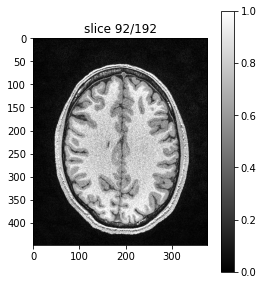

In [4]:
filename = "data/MPR_500um_32_run01_nuCorrect_aligned.nii"
img1 = read_nii_image(filename)
print(f"shape of img: {img1.shape}")
slice_num = np.random.randint(img1.shape[-1])
visualize_nii_slice(img1, slice_num)

shape of img: (378, 448, 192)


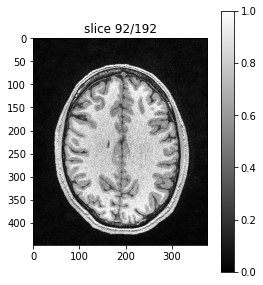

In [5]:
filename = "data/MPR_500um_32_run02_nuCorrect_aligned.nii"
img2 = read_nii_image(filename)
print(f"shape of img: {img2.shape}")
visualize_nii_slice(img2, slice_num)

shape of img: (378, 448, 192)


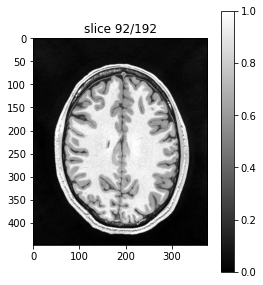

In [6]:
filename = "data/MPR_500um_32_avg.norm.norm.nii"
img_ref = read_nii_image(filename)
print(f"shape of img: {img_ref.shape}")
visualize_nii_slice(img_ref, slice_num)

## 2. Denoising

In [7]:
import helpers.config as config
from helpers.non_local_means import NonLocalMeansDenoiser

In [8]:
# config.config_win_size_grid, config.config_tau_grid

In [9]:
# args = dict(imgs = [img1, img2], ref_img = img_ref)
# denoiser = NonLocalMeansDenoiser(**args)

In [10]:
# slice_num = np.random.randint(denoiser.denoised_img.shape[-1])
# denoiser.plot_img(denoiser.denoised_img, slice_num)

In [11]:
# doc = denoiser.denoise()

In [12]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from helpers.non_local_means import NonLocalMeansDenoiserSkimage

In [13]:
args = dict(imgs = [img1, img2], ref_img = img_ref)
denoiser = NonLocalMeansDenoiserSkimage(**args)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

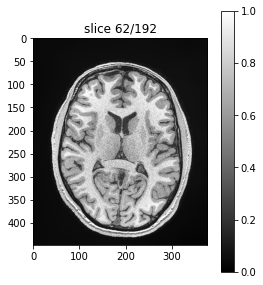

In [14]:
doc = denoiser.denoise()

In [15]:
import pickle

with open("doc_notebook.pkl", "wb") as wf:
    pickle.dump(doc, wf)

In [16]:
# slice_num = np.random.randint(img1.shape[-1])
# sigma_est = estimate_sigma(img1[..., slice_num])
# img_denoised = denoise_nl_means(img1[..., slice_num], patch_size=5,
#                                 patch_distance=6, h=0.1 * sigma_est, sigma=sigma_est)

In [17]:
# plt.imshow(img_denoised.T, cmap="gray")

In [18]:
# plt.imshow((img_denoised - img1[..., slice_num]).T, cmap="gray")
# plt.colorbar()

## 3. TV

In [46]:
from helpers.total_variance import TVDenoiser
from helpers.utils import rmse

In [47]:
import pickle

with open("./doc.pkl", "rb") as rf:
    doc_script = pickle.load(rf)
    last_img = doc_script["imgs"][-1]

del doc_script

In [48]:
args = dict(imgs = [img1, img2], ref_img = img_ref)
denoiser = TVDenoiser(**args)

  0%|          | 0/5 [00:00<?, ?it/s]

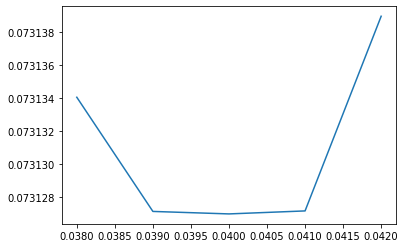

In [49]:
doc = denoiser.compute_diff_weights()

In [50]:
# with open("./doc_tv_orig_notebook.pkl", "wb") as wf:
#     pickle.dump([config.config_weights_grid, doc], wf)

In [51]:
# change config.config_weight_min and comfig.config_weight_max
config.config_weights_grid

array([0.038, 0.039, 0.04 , 0.041, 0.042])

  0%|          | 0/5 [00:00<?, ?it/s]

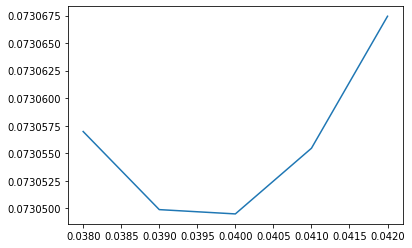

In [52]:
doc_nlm = denoiser.compute_diff_weights(img=last_img)

In [53]:
# with open("./doc_tv_nlm_notebook.pkl", "wb") as wf:
#     pickle.dump([config.config_weights_grid, doc_nlm], wf)

In [65]:
# with open("./results/doc.pkl", "rb") as rf:
#     doc = pickle.load(rf)
#     last_img = doc["imgs"][-1]
#     del doc

# with open("best_nlm.pkl", "wb") as wf:
#     pickle.dump(last_img, wf)

## 4. Save the Best Result

In [66]:
with open("best_nlm.pkl", "rb") as rf:
    best_nlm = pickle.load(rf)

In [67]:
weight = 0.039  # by grid search

In [69]:
from skimage.restoration import denoise_tv_chambolle
from helpers.utils import rmse

In [70]:
img_denoised = denoise_tv_chambolle(best_nlm, weight)

In [71]:
rmse(img_ref, img_denoised)

0.07304988150241479

In [74]:
from helpers.utils import save_nii_image

In [76]:
# filename = "./results/denoised.nii"
# save_nii_image(img_denoised, filename)

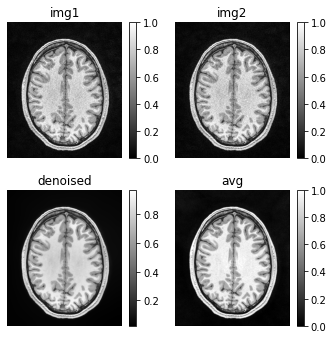

In [86]:
slice_num = 97
fig, axes = plt.subplots(2, 2, figsize=(4.8, 4.8))
titles = [["img1", "img2"],
         ["denoised", "avg"]]
imgs = [[img1, img2],
       [img_denoised, img_ref]]
for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axis = axes[i, j]
        handle = axis.imshow(imgs[i][j][..., slice_num].T, cmap="gray")
        plt.colorbar(handle, ax=axis)
        axis.set_title(titles[i][j])
        axis.axis("off")
fig.tight_layout()
fig.savefig(f"./results/result_{slice_num}.png")